This notebook will focus on Exerices 10 from Hands_On_Machine Learning Chapter 10

In [94]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt


In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

In [31]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

In [32]:
X_train.shape

(55000, 28, 28)

In [33]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

In [34]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [60]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=X_train.shape[1:]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation='softmax')
])

In [61]:
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
loss = keras.losses.sparse_categorical_crossentropy

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [59]:
expon_lr = ExponentialLearningRate(factor=1.0045)

In [62]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

1719/1719 [==============================] - 4s 2ms/step - loss: nan - accuracy: 0.6523 - val_loss: nan - val_accuracy: 0.0958


Text(0, 0.5, 'Loss')

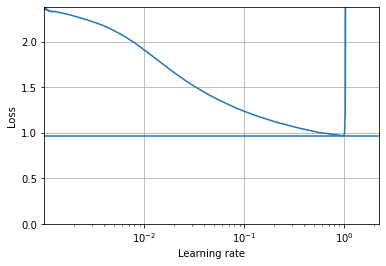

In [63]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [67]:
prime_lr = expon_lr.rates[expon_lr.losses.index(min(expon_lr.losses))] / 10

In [85]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [86]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [87]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=prime_lr),
              metrics=["accuracy"])

In [73]:
import os
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir(lr):
    return os.path.join(root_logdir, "run_").join(str(lr))
run_logdir = get_run_logdir(prime_lr)

In [84]:
run_index = 1 # increment this at every run
run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index))
run_logdir

'./my_mnist_logs/run_001'

In [88]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2778 - accuracy: 0.9170 - val_loss: 0.1280 - val_accuracy: 0.9640
Epoch 2/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1120 - accuracy: 0.9667 - val_loss: 0.0977 - val_accuracy: 0.9720
Epoch 3/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0758 - accuracy: 0.9766 - val_loss: 0.0776 - val_accuracy: 0.9770
Epoch 4/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0549 - accuracy: 0.9831 - val_loss: 0.0731 - val_accuracy: 0.9782
Epoch 5/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0414 - accuracy: 0.9871 - val_loss: 0.0740 - val_accuracy: 0.9798
Epoch 6/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0303 - accuracy: 0.9907 - val_loss: 0.0641 - val_accuracy: 0.9832
Epoch 7/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0224 - accuracy: 0.9933 - val_loss: 0.0675 - val_ac

In [89]:
model = keras.models.load_model("my_mnist_model.h5") # rollback to best model
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 1ms/step - loss: 0.0615 - accuracy: 0.9808


[0.06145576760172844, 0.9807999730110168]

In [83]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [93]:
%tensorboard --logdir=./my_mnist_logs --load_fast true